In [89]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [90]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 10:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [91]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [92]:
def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #link
    news_headline = news_tag.find('a').text #heading
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'content' : news_content,
           }

In [93]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    print('Requesting html page')
    doc = get_page(url)

    print('Extracting news tags')
    news_list = get_news_tags(doc)

    print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [94]:
# url = 'https://finance.yahoo.com/topic/stock-market-news/'
# doc = get_page(url)
# news_list = get_news_tags(doc)
# news_list

# Entire Stock Market News

In [95]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

print(date.today())
YAHOO_NEWS_URL = 'https://finance.yahoo.com/topic/stock-market-news/'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Current Time = 01:37:43
2022-12-08
Requesting html page
Extracting news tags
Parsing news tags
Save the data to a CSV


In [96]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [97]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [98]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [99]:
news_df

,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,Reuters,8 minutes ago,"Stolen data of 600,000 Indians sold on bot markets so far - study","Around five million people globally have had their data stolen and sold on the bot market till date, of which 600,000 are from India, making it the worst affected country, according to one of the world's largest VPN serice providers NordVPN. Bot markets are used by hackers to sell stolen data from victims' devices with bot malware. The study by NordVPN, of Lithuania's Nord Security, said the stolen data included user logins, cookies, digital fingerprints, screenshots and other information,...",NEGATIVE,0.999270,NEGATIVE,0.999625
1,Barrons.com,8 minutes ago,Wells Fargo Stock Is Primed to Jump Higher. How to Play It.,"Wells Fargo’s broad ownership among hedge funds and mutual funds is an intriguing revelation, suggesting that January’s earnings report could act as a spring-loaded event.",POSITIVE,0.995651,POSITIVE,0.998907
2,Bloomberg,15 minutes ago,Hong Kong Stocks Rally on Report City May Relax Covid Rules,"(Bloomberg) -- Hong Kong stocks jumped following a report that the government may further loosen Covid-related restrictions, with shares related to the economy’s reopening surging. Most Read from BloombergPutin Calls Russian Nukes Deterrent Factor, Says War Risk RisingPeru’s President Accused of Coup After Move to Dissolve CongressWhy Did So Many US Men Quit Working? Social Status May Hold the Key, Study SaysBe Careful, Here Come the Predictions for 2023Musk Spars With San Francisco Over Pro...",NEGATIVE,0.903686,NEGATIVE,0.989587
3,Bloomberg,1 hour ago,"Stocks Mixed on China Reopening, Recession Fears: Markets Wrap","(Bloomberg) -- Stocks in Asia fluctuated following signs China would further relax its Covid restrictions, while Treasuries flashed warning signs of recession. The dollar strengthened in an indication of demand for havens.Most Read from BloombergPutin Calls Russian Nukes Deterrent Factor, Says War Risk RisingPeru’s President Accused of Coup After Move to Dissolve CongressWhy Did So Many US Men Quit Working? Social Status May Hold the Key, Study SaysBe Careful, Here Come the Predictions for 2...",NEGATIVE,0.983804,POSITIVE,0.792228
4,Investor's Business Daily,3 hours ago,Why This Market Rally Is So Dangerous; Tesla Nears Bear Lows On This Move,"The market rally is holding key levels, but the choppy action is dangerous. Tesla stock fell toward bear market lows amid new China discounts.",NEGATIVE,0.998698,NEGATIVE,0.999591
5,Reuters,4 hours ago,"China, Hong Kong stocks lift Asian equities; growth worries loom","Asian equities rose on Thursday, propped up by Hong Kong and China stocks amid growing optimism over an easing of COVID restrictions in the world's second biggest economy even as fears of a slowdown and worries over Fed interest rate rises linger. MSCI's broadest index of Asia-Pacific shares outside Japan was up 0.57%, on track to snap a two-day losing streak. China's stock market was 0.14% higher, with Hong Kong's Hang Seng Index surging nearly 3% after a pro-China newspaper reported that...",POSITIVE,0.997117,NEGATIVE,0.964881
6,Zacks,5 hours ago,Are Options Traders Betting on a Big Move in Peabody (BTU) Stock?,Investors need to pay close attention to Peabody (BTU) stock based on the movements in the options market lately.,NEGATIVE,0.997869,NEGATIVE,0.995064
7,Reuters,5 hours ago,FTX founder Sam Bankman-Fried is said to face market manipulation inquiry by U.S. prosecutors - NYT,"The prosecutors are looking into whether Bankman-Fried controlled the prices of two interlinked currencies, TerraUsd and Luna, to benefit the entities he controlled including FTX and Alameda Research, the report said. The investigation is in its early stages, the newspaper said, adding that it is not clear whether prosecutors have determined any wrongdoing by Bankman-Fried, or when they began looking at the TerraUSD and Luna trades.",NEGATIVE,0.995224,NEGATIVE,0.999122
8,Fox 

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

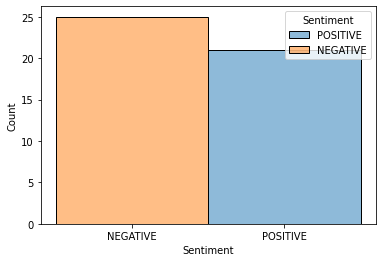

In [100]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment2', ylabel='Count'>

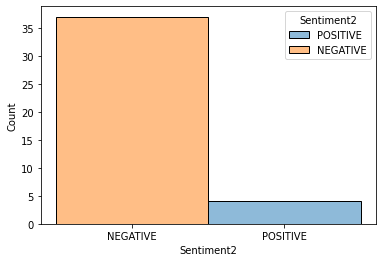

In [101]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE'])

In [102]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [103]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)


## Headline

In [104]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

In [105]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

## Content

In [106]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

In [107]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

In [108]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

# SPY Ticker

In [109]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [110]:
url = "https://finviz.com/quote.ashx?t=SPY&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [111]:
df = pd.DataFrame(sentence2)

In [112]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [113]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i


In [114]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score


In [115]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [116]:
df[df['Score'] > 0.8]

,Headline,Sentiment,word_count,Score,Headline_Lower
24,"ETF tracking S&P 500 sees highest number of sharp moves down this year since 2008, Bespoke finds",NEGATIVE,17,0.974795,"etf tracking s&p 500 sees highest number of sharp moves down this year since 2008, bespoke finds"
26,The 3 Most Popular Robinhood ETFs -- and Why Warren Buffett Loves 2 of Them,POSITIVE,15,0.998836,the 3 most popular robinhood etfs -- and why warren buffett loves 2 of them
27,Should SPDR S&P 500 ETF (SPY) Be on Your Investing Radar?,NEGATIVE,11,0.998921,should spdr s&p 500 etf (spy) be on your investing radar?
31,S&P 500 companies will have zero earnings growth in 2023: Goldman Sachs,NEGATIVE,12,0.999660,s&p 500 companies will have zero earnings growth in 2023: goldman sachs
38,Is SPY Stock A Buy Right Now? What To Know About World's Top Index,NEGATIVE,14,0.991594,is spy stock a buy right now? what to know about world's top index
42,"Market check: S&P 500 breaks above 3,900 level, bond volatility crashes",NEGATIVE,11,0.999228,"market check: s&p 500 breaks above 3,900 level, bond volatility crashes"
43,Market rally may be the signal the market has been waiting for on slowing Fed rates: Author,NEGATIVE,17,0.989480,market rally may be the signal the market has been waiting for on slowing fed rates: author
52,The Only 2 Index Funds in Warren Buffett's Portfolio -- and How They Could Make You Money,NEGATIVE,17,0.992571,the only 2 index funds in warren buffett's portfolio -- and how they could make you money
53,"Powell Talks a Hawkish Game, but Will Be Wary of Another Policy Mistake",NEGATIVE,13,0.990042,"powell talks a hawkish game, but will be wary of another policy mistake"
55,"The S&P 500 'could carry all the way to 4,000' points: Strategist",NEGATIVE,12,0.843909,"the s&p 500 'could carry all the way to 4,000' points: strategist"


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

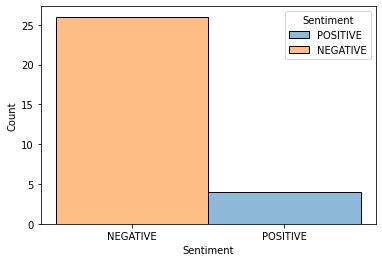

In [117]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# NUSI Ticker

In [118]:
url = "https://finviz.com/quote.ashx?t=NUSI&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [119]:
df = pd.DataFrame(sentence2)

In [120]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [121]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i


In [122]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score


In [123]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [124]:
df[df['Score'] > 0.8]

,Headline,Sentiment,word_count,Score,Headline_Lower
26,Aflac CEO: Let politics fall where they may on racial justice,NEGATIVE,11,0.998484,aflac ceo: let politics fall where they may on racial justice


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

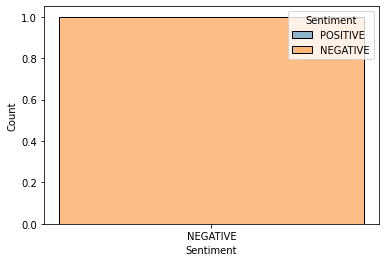

In [125]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# XOM YF

In [126]:
YAHOO_NEWS_URL = 'https://finance.yahoo.com/quote/XOM/news?p=XOM'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Requesting html page
Extracting news tags
Parsing news tags
Save the data to a CSV


In [127]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [128]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [129]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [130]:
import seaborn as sns

In [131]:
news_df

,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,MoneyWise,8 hours ago,Winter is coming: The 'best country in the world' is planning to ban electric cars amid the energy crisis. Is it time to revisit oil stocks? Here are 3 big plays,Wake up and smell the diesel.,NEGATIVE,0.992041,POSITIVE,0.975145
1,Insider Monkey,9 hours ago,11 Best Low-Risk Dividend Stocks to Invest In,"In this article, we discuss 11 best low-risk dividend stocks to invest in. You can skip our detailed analysis on dividend investment and their returns in the past, and go directly to read 5 Best Low-Risk Dividend Stocks to Invest In. The stock market has been rocky throughout this year, making investors anxious about the […]",POSITIVE,0.999301,NEGATIVE,0.973663
2,Bloomberg,11 hours ago,Exxon’s US Workers Get Inflation-Busting Pay Hike as Profit Hits Record,"(Bloomberg) -- Exxon Mobil Corp. is awarding US employees above-inflation pay increases just weeks after the Texas oil giant posted its highest quarterly profit, underlining how strong 2022 has been for the fossil-fuel industry while other sectors like technology and finance cut jobs.Most Read from BloombergPutin Calls Russian Nukes Deterrent Factor, Says War Risk RisingPeru’s President Accused of Coup After Move to Dissolve CongressWhy Did So Many US Men Quit Working? Social Status May Hold...",NEGATIVE,0.986448,NEGATIVE,0.978648
3,Motley Fool,15 hours ago,2 Dividend Aristocrats to Buy for 2023,"Heading into next year, a couple of Aristocrats that look to be good investments are Abbott Laboratories (NYSE: ABT) and ExxonMobil (NYSE: XOM). Healthcare giant Abbott Laboratories has a diverse business that generates over $1 billion in revenue every quarter from multiple segments, including medical devices, pharmaceuticals, diagnostics, and nutrition. Abbott has since restarted production and, assuming no interruptions happen again, next year should be a stronger one for that segment as...",NEGATIVE,0.907515,POSITIVE,0.694557
4,Investor's Business Daily,17 hours ago,"Dow Jones Futures Fall: Market Rally Wipes Out Powell Gains As Apple, Exxon, Tesla Skid","Futures fell after the market rally erased gains from Fed chief Jerome Powell's Nov. 30 speech. Apple, Exxon broke below key levels.",NEGATIVE,0.999235,NEGATIVE,0.999378
5,Zacks,19 hours ago,"The Zacks Analyst Blog Highlights Exxon Mobil, WesBanco, S&T Bancorp, Gilead Sciences and Conagra Brands","Exxon Mobil, WesBanco, S&T Bancorp, Gilead Sciences and Conagra Brands are included in this Analyst Blog.",POSITIVE,0.987182,POSITIVE,0.741008
6,Motley Fool,2 days ago,"Why Chevron, Exxon, and Kinder Morgan All Fell Today","Shares of major oil stocks, including diversified majors Chevron (NYSE: CVX), ExxonMobil (NYSE: XOM), and pipeline giant Kinder Morgan (NYSE: KMI) all fell on Tuesday, declining 2.4%, 3%, and 2.6%, respectively, as of 2:41 p.m. ET. The entire market was down today, as recession fears appeared to loom over most stocks. A recession of course wouldn't be good for any commodity, oil and gas included.",NEGATIVE,0.999408,NEGATIVE,0.999698
7,MarketWatch,2 days ago,"World will face shortage of liquefied natural gas through 2026, says Exxon CEO",Russia cut supplies of natural gas to Europe in response to the wave of international sanctions that followed Moscow's invasion of Ukraine.,NEGATIVE,0.991765,NEGATIVE,0.995576
8,Zacks,2 days ago,Amcor (AMCR) Inks Deal to Buy Recycled Material From Exxon Mobil,Amcor (AMCR) enters into an agreement with Exxon Mobil to purchase recycled materials for its food and healthcare markets.,NEGATIVE,0.998305,NEGATIVE,0.978695
9,Insider Monkey,2 days ago,10 Best Performing Commodity ETFs in 2022,"In this article, we discuss 10 best performing commodity ETFs in 2022. If you want to see more ETFs in this selection, check out 5 Best Performing Commodity ETFs in 2022. As per a new S&P Global Market Intelligence report, dated November 4, commodities prices for core metals will be hit by the macro backdrop […]",POSI

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

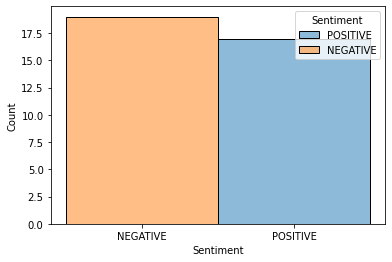

In [132]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment2', ylabel='Count'>

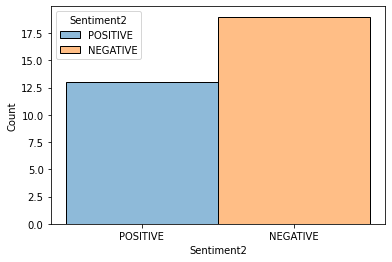

In [133]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE'])

# XOM Ticker

In [134]:
url = "https://finviz.com/quote.ashx?t=XOM&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [135]:
df = pd.DataFrame(sentence2)

In [136]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [137]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i


In [138]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score


In [139]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [140]:
df[df['Score'] > 0.8]

,Headline,Sentiment,word_count,Score,Headline_Lower
25,Winter is coming: The 'best country in the world' is planning to ban electric cars amid the energy crisis,POSITIVE,19,0.962461,winter is coming: the 'best country in the world' is planning to ban electric cars amid the energy crisis
27,Exxons US Workers Get Inflation-Busting Pay Hike as Profit Hits Record,NEGATIVE,11,0.988407,exxons us workers get inflation-busting pay hike as profit hits record
29,"Dow Jones Futures Fall: Market Rally Wipes Out Powell Gains As Apple, Exxon, Tesla Skid",NEGATIVE,15,0.999235,"dow jones futures fall: market rally wipes out powell gains as apple, exxon, tesla skid"
30,"Market Rally Wipes Out Powell Gains As Apple, Exxon Skid; What To Do Now",NEGATIVE,14,0.999011,"market rally wipes out powell gains as apple, exxon skid; what to do now"
31,"The Zacks Analyst Blog Highlights Exxon Mobil, WesBanco, S&T Bancorp, Gilead Sciences and Conagra Brands",POSITIVE,15,0.987182,"the zacks analyst blog highlights exxon mobil, wesbanco, s&t bancorp, gilead sciences and conagra brands"
33,"World will face shortage of liquefied natural gas through 2026, says Exxon CEO",NEGATIVE,13,0.991765,"world will face shortage of liquefied natural gas through 2026, says exxon ceo"
34,Amcor (AMCR) Inks Deal to Buy Recycled Material From Exxon Mobil,NEGATIVE,11,0.998305,amcor (amcr) inks deal to buy recycled material from exxon mobil
36,Investors Heavily Search Exxon Mobil Corporation (XOM): Here is What You Need to Know,NEGATIVE,14,0.989767,investors heavily search exxon mobil corporation (xom): here is what you need to know
41,"BP stake in Russian oil giant Rosneft is blood money, says adviser to Ukraines President Zelensky",NEGATIVE,16,0.989420,"bp stake in russian oil giant rosneft is blood money, says adviser to ukraines president zelensky"
43,Energy stocks mixed as China demand looks supportive of oil prices,NEGATIVE,11,0.995578,energy stocks mixed as china demand looks supportive of oil prices


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

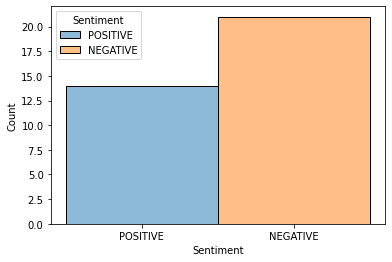

In [141]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# SQQQ Ticker

In [142]:
url = "https://finviz.com/quote.ashx?t=SQQQ&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [143]:
df = pd.DataFrame(sentence2)

In [144]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [145]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i


In [146]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score


In [147]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [148]:
df[df['Score'] > 0.8]

,Headline,Sentiment,word_count,Score,Headline_Lower
26,"Jackson Hole Capital Partners, LLC Buys Rent-A-Center Inc, Direxion Daily S&P 500 Bear 3X",NEGATIVE,14,0.974540,"jackson hole capital partners, llc buys rent-a-center inc, direxion daily s&p 500 bear 3x"
27,"Hengehold Capital Management Llc Buys Schwab US Aggregate Bond ETF, iShares National Muni Bond",NEGATIVE,14,0.969672,"hengehold capital management llc buys schwab us aggregate bond etf, ishares national muni bond"
30,"St Denis J Villere & Co LLC Buys Bank of America Corp, Paya Holdings Inc, Open Lending",POSITIVE,17,0.978686,"st denis j villere & co llc buys bank of america corp, paya holdings inc, open lending"
42,Rise of online ordering will continue after COVID-19: Yum China CEO,POSITIVE,11,0.998168,rise of online ordering will continue after covid-19: yum china ceo
49,NASDAQ Makes It Four Days of Gains as Stocks Resume Rally,NEGATIVE,11,0.972605,nasdaq makes it four days of gains as stocks resume rally
51,The stock market is getting dangerously close to the mother of support zones,NEGATIVE,13,0.995923,the stock market is getting dangerously close to the mother of support zones
52,To the investors gobbling up stocks: The intraweek rally attempt faces a better-than-even chance of failure,NEGATIVE,16,0.998739,to the investors gobbling up stocks: the intraweek rally attempt faces a better-than-even chance of failure
53,How low can the stock market go? Watch these two support zones,NEGATIVE,12,0.999458,how low can the stock market go? watch these two support zones
54,"Dos and donts in this stock market: Dont panic, do develop a plan even if you didnt have one before",NEGATIVE,21,0.993685,"dos and donts in this stock market: dont panic, do develop a plan even if you didnt have one before"
55,Stock market investors are asking should I buy or sell? Heres how to decide,NEGATIVE,14,0.998444,stock market investors are asking should i buy or sell? heres how to decide


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

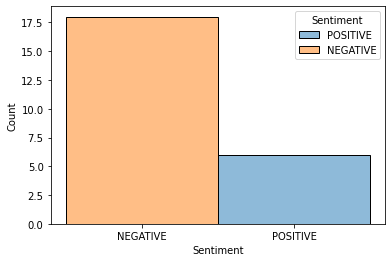

In [149]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

# T.TO

In [150]:
YAHOO_NEWS_URL = 'https://finance.yahoo.com/quote/T.TO/news?p=T.TO'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Requesting html page
Extracting news tags
Parsing news tags
Save the data to a CSV


In [151]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [152]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [153]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [154]:
import seaborn as sns

In [155]:
news_df

,source,time,headline,content,Sentiment,Score,Sentiment2,Score2
0,Insider Monkey,2 days ago,12 Best Communication Stocks To Buy Today,"In this article, we discuss the 12 best communication stocks to buy today. If you want to read about some more communication stocks to buy today, go directly to 5 Best Communication Stocks To Buy Today. The communications industry has grown from a sector that used to include just telecommunications, newspapers, magazines, books, and radio […]",POSITIVE,0.999457,POSITIVE,0.994583
1,Simply Wall St.,3 days ago,TELUS Corporation (TSE:T) is largely controlled by institutional shareholders who own 54% of the company,"If you want to know who really controls TELUS Corporation ( TSE:T ), then you'll have to look at the makeup of its...",NEGATIVE,0.892858,NEGATIVE,0.999047
2,Simply Wall St.,22 days ago,TELUS' (TSE:T) Dividend Will Be Increased To CA$0.3511,TELUS Corporation ( TSE:T ) has announced that it will be increasing its dividend from last year's comparable payment...,NEGATIVE,0.988017,NEGATIVE,0.933608
3,Financial Post,24 days ago,"Telus had strategy to 'kill, shape and slow' Rogers-Shaw merger, document shows",Telus’s efforts included company executives meeting with political leaders to try to persuade them to reject the takeover,NEGATIVE,0.997785,NEGATIVE,0.913936
4,Reuters,24 days ago,Rogers says Telus documents show rival tried to 'kill' Shaw deal,"In its effort to win takeover approval, telecom provider Rogers Communications Inc on Monday presented documents to a tribunal that show Canada's second-largest telecom company Telus Corp attempted to sabotage Rogers' C$20 billion ($15 billion) deal to buy Shaw Communications Inc. Challenging Canadian regulators' rejection of the deal on anti-trust grounds, Rogers may seek to argue that Telus wanted to kill the acquisition because it would increase cellphone competition, benefiting Canadian...",NEGATIVE,0.994781,NEGATIVE,0.996364
5,Zacks,24 days ago,DTEGY or TU: Which Is the Better Value Stock Right Now?,DTEGY vs. TU: Which Stock Is the Better Value Option?,NEGATIVE,0.998896,NEGATIVE,0.998626
6,Simply Wall St.,last month,Is TELUS Corporation's (TSE:T) 12% ROE Better Than Average?,"While some investors are already well versed in financial metrics (hat tip), this article is for those who would like...",NEGATIVE,0.999067,POSITIVE,0.996413
7,Zacks,last month,"TELUS (TU) Q3 Earnings & Revenues Top Estimates, Increase Y/Y",TELUS (TU) third-quarter performance boosted by high service revenue in TELUS technology solutions and TELUS International.,NEGATIVE,0.692262,POSITIVE,0.791908
8,Benzinga,last month,Telus Clocks ~10% Revenue Growth In Q3 Backed By Customer Additions; Boosts Dividend By 7.2%,"Telus Corp (NYSE: TU) reported third-quarter FY22 operating revenues and other income growth of 9.9% year-on-year to CA$4.67 billion. Total telecom subscriber connections grew 6.3% Y/Y to 17.7 million. It made 347,000 new customer net additions in the quarter, up 27,000 over last year, including 150,000 mobile phones, 124,000 connected devices, 36,000 internet, 25,000 security, and 18,000 TV customer connections. The mobile phone churn was 0.95%. Adjusted basic EPS was CA$0.34, up 17% Y/Y. A...",NEGATIVE,0.561149,NEGATIVE,0.983207
9,Zacks,last month,Telus (TU) Q3 Earnings and Revenues Beat Estimates,"Telus (TU) delivered earnings and revenue surprises of 4% and 1.93%, respectively, for the quarter ended September 2022. Do the numbers hold clues to what lies ahead for the stock?",NEGATIVE,0.955190,NEGATIVE,0.994703


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

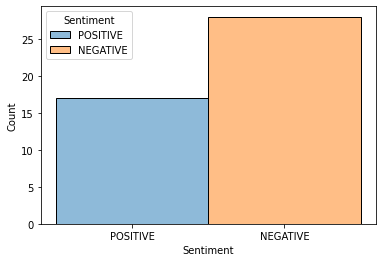

In [156]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment2', ylabel='Count'>

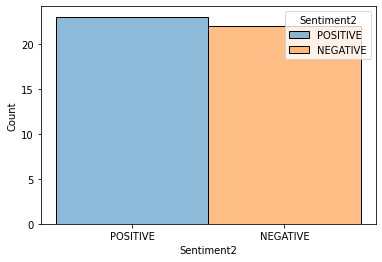

In [157]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE'])